Загрузка библиотек

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy 
from scipy import stats
from scipy.stats import shapiro

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

import statsmodels as sm
from statsmodels.stats.power import TTestIndPower

Подготовим данные, загрузим и проверим корректность отображения.

In [3]:
df = pd.read_excel('gb_sem_8_hm.xlsx')
df.head(10)

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
5,2380,variant,0.0
6,2849,control,0.0
7,9168,control,0.0
8,6205,variant,0.0
9,7548,control,0.0


Проверим столбцы на правильность типов и наличие нулевых значений

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [5]:
df.shape

(10000, 3)

In [6]:
df.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


In [7]:
df.isna().sum()

USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64

Посмотрим количество пользователей в каждой из групп

In [8]:
df.VARIANT_NAME.value_counts()

VARIANT_NAME
variant    5016
control    4984
Name: count, dtype: int64

Проверим не попали ли одни и теже пользователи в разные выборки

In [9]:
df.USER_ID.nunique()

6324

In [10]:
df = df.groupby(['USER_ID', 'VARIANT_NAME'], as_index=False).agg({'REVENUE': 'sum'})

In [11]:
df.shape

(7865, 3)

In [12]:
df.groupby('USER_ID', as_index=False).agg({'VARIANT_NAME': 'count'})['VARIANT_NAME'].value_counts()

VARIANT_NAME
1    4783
2    1541
Name: count, dtype: int64

Избавимся от некорретных строк. Посчитаем, сколько типов встречается у каждого пользователя.

In [20]:
v = df.\
    groupby('USER_ID', as_index=False).\
    agg({'VARIANT_NAME': pd.Series.nunique})

In [21]:
more_than_one_types = v.query('VARIANT_NAME > 1')
df_new = df[~df.USER_ID.isin(more_than_one_types.USER_ID)].sort_values('USER_ID')

In [22]:
df_new.shape

(4783, 3)

In [23]:
df_new.describe()

,USER_ID,REVENUE
count,4783.000000,4783.000000
mean,4994.395777,0.135873
std,2898.618472,3.011392
min,2.000000,0.000000
25%,2476.000000,0.000000
50%,4975.000000,0.000000
75%,7515.000000,0.000000
max,9998.000000,196.010000


In [24]:
control = df_new.query('VARIANT_NAME == "control"')

test = df_new.query('VARIANT_NAME == "variant"')

**Проверка на нормальность**

In [25]:
alpha = 0.05

st = shapiro(df.REVENUE)
print('Discription is {}normal\n'.format( {True: 'not ',
False: ''}[st[1] < alpha]));

Discription is not normal



Постороим график дохода на юзера по группам

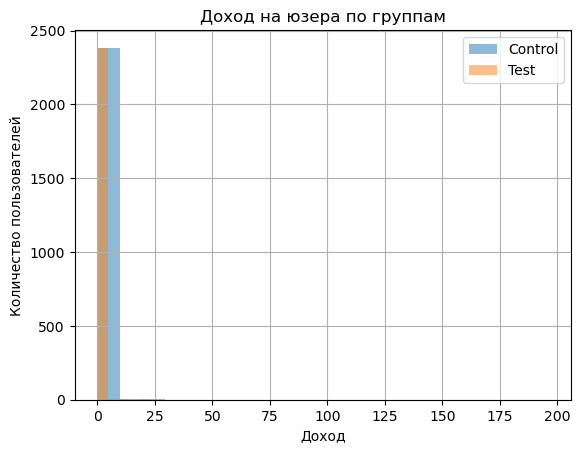

In [33]:
control.REVENUE.hist(bins = 20, alpha = 0.5, label = 'Control')
test.REVENUE.hist(bins = 5, alpha = 0.5, label = 'Test')
plt.title('Доход на юзера по группам')
plt.xlabel('Доход')
plt.ylabel('Количество пользователей')
plt.legend();

In [34]:
mw_stats = scipy.stats.mannwhitneyu(x=control.REVENUE.values, y = test.REVENUE.values)

mw_stats

MannwhitneyuResult(statistic=2874161.0, pvalue=0.2104875008271777)

Построим Боксплот по пользователям

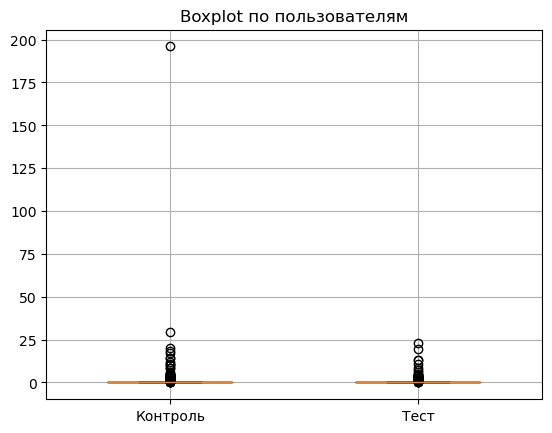

In [21]:
plt.boxplot([control.REVENUE, test.REVENUE],
            labels = ['Контроль', 'Тест'],
            widths = 0.5
            )
plt.title('Boxplot по пользователям', loc='center')
plt.grid(axis='both')

In [22]:
stats.ttest_ind(control.REVENUE.values, test.REVENUE.values, equal_var = False)

Ttest_indResult(statistic=1.3996978409515475, pvalue=0.16172355638776942)

**Расчёт мощности теста**

In [23]:
C_mean = control.REVENUE.values.mean()
T_mean = test.REVENUE.values.mean()

C_std = control.REVENUE.values.std()
T_std = test.REVENUE.values.std()

print(len(control.REVENUE.values), len(test.REVENUE.values))

2390 2393


In [24]:
n = len(control.REVENUE.values)
     
S = np.sqrt((T_std**2 +C_std**2)/2)
     
ef = float((C_mean-T_mean)/S)

In [25]:
alpha = 0.05
analysis = TTestIndPower()
analysis = sm.stats.power.TTestIndPower()
result = analysis.solve_power(ef, power=None,
                              nobs1=n, ratio=1.0, alpha=alpha)

result

0.28803096229144043

**Рекомендации:**

* Статистически значимая разница между группами не обнаружена
* Необходим А/А тест, для проверки работы сплитования
* Проведён тест недостаточной мощности, чтобы была возможность использовать данные для принятия решения
* После исправлений и уточнений необходим повторный тест.